In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


1A # --- 1. Load Data (Menggunakan Relative Path) ---

In [3]:

try:
    df = pd.read_csv('secondary_data.csv', sep=';')
except FileNotFoundError:
    print("Error: File 'secondary_data.csv' tidak ditemukan. Pastikan sudah diunggah.")
    exit()

# --- 2. Data Cleaning & Target Encoding ---


In [4]:
# Target Encoding: 'p' (poisonous) -> 1, 'e' (edible) -> 0
df['class'] = df['class'].map({'p': 1, 'e': 0})

In [5]:
# Pisahkan fitur (X) dan target (y)
X = df.drop('class', axis=1)
y = df['class']

In [6]:
# Identifikasi Tipe Kolom
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['float64']).columns

# --- 3. Membuat Preprocessing Pipeline ---

In [7]:
# Transformer untuk fitur Kategorikal (Imputasi Modus & One-Hot Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [8]:
# Transformer untuk fitur Numerikal (Standard Scaling)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [9]:
# Menggabungkan semua Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [10]:
# Terapkan Preprocessing
X_processed = preprocessor.fit_transform(X)

print(f"Preprocessing Selesai. Total Fitur Baru: {X_processed.shape[1]}")

Preprocessing Selesai. Total Fitur Baru: 119


In [11]:
# --- 4. Pembagian Data (Train & Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Penting untuk menjaga proporsi kelas
)

print(f"Ukuran Data Latih (Train Set): {X_train.shape}")
print(f"Ukuran Data Uji (Test Set): {X_test.shape}")

Ukuran Data Latih (Train Set): (48855, 119)
Ukuran Data Uji (Test Set): (12214, 119)


In [12]:
# --- 5. Fungsi Global untuk Evaluasi ---
# Inisialisasi list global untuk menyimpan hasil
global_results = []

def evaluate_and_store(y_true, y_pred, model_name):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Metrik standar
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Metrik Kritis: False Negative (FN)
    fn = np.sum((y_true == 1) & (y_pred == 0))

    global_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'False Negative (FN)': fn
    })

    # Print log hasil evaluasi
    print(f"\n--- Hasil Evaluasi {model_name} ---")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall (Kritis): {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  False Negative (FN): {fn}")


MODEL 1 - LOGISTIC REGRESSION (BASELINE)

In [13]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Inisialisasi model dengan hyperparameter dasar
lr_model = LogisticRegression(
    solver='liblinear',
    random_state=42,
    max_iter=500,
    n_jobs=-1
)


In [14]:
# Latih model menggunakan data training
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, solver='liblinear')

In [15]:
# Prediksi pada Test Set
y_pred_lr = lr_model.predict(X_test)

In [16]:
# Evaluasi dan simpan hasil
evaluate_and_store(y_test, y_pred_lr, 'Logistic Regression (Baseline)')



--- Hasil Evaluasi Logistic Regression (Baseline) ---
  Accuracy: 0.8472
  Precision: 0.8688
  Recall (Kritis): 0.8536
  F1-Score: 0.8611
  False Negative (FN): 992


In [17]:
# Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
class_labels = ['Edible (0)', 'Poisonous (1)']

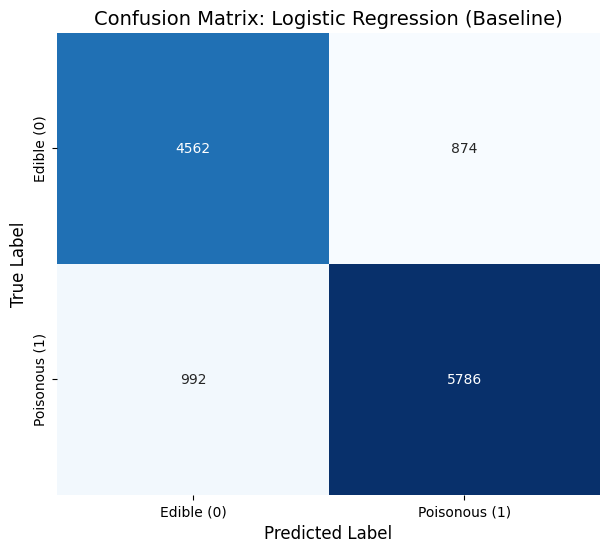

Visualisasi Logistic Regression Selesai.


In [18]:
# Plot Heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar=False)

plt.title('Confusion Matrix: Logistic Regression (Baseline)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.savefig('lr_confusion_matrix.png')
plt.show()

print("Visualisasi Logistic Regression Selesai.")


In [39]:
import joblib
import os

# 1. Pastikan folder 'models' tersedia
if not os.path.exists('models'):
    os.makedirs('models')

# 2. Simpan model ke dalam file .pkl
model_filename = 'models/model_baseline.pkl'
joblib.dump(lr_model, model_filename)

print(f"✅ Model berhasil disimpan secara lokal di: {model_filename}")


✅ Model berhasil disimpan secara lokal di: models/model_baseline.pkl


MODEL 2 - RANDOM FOREST CLASSIFIER (ADVANCED ML)

In [20]:
# Inisialisasi model dengan hyperparameter yang memberikan performa non-linier yang baik
rf_model = RandomForestClassifier(
    n_estimators=100, # Jumlah pohon
    max_depth=10,     # Kedalaman maksimum pohon
    random_state=42,
    n_jobs=-1
)

In [21]:
# Latih model menggunakan data training
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [22]:
# Prediksi pada Test Set
y_pred_rf = rf_model.predict(X_test)


In [23]:
# Evaluasi dan simpan hasil
evaluate_and_store(y_test, y_pred_rf, 'Random Forest (Advanced ML)')
print("-" * 60)


--- Hasil Evaluasi Random Forest (Advanced ML) ---
  Accuracy: 0.9628
  Precision: 0.9774
  Recall (Kritis): 0.9551
  F1-Score: 0.9661
  False Negative (FN): 304
------------------------------------------------------------


In [37]:
# 2. Simpan model ke dalam file .pkl
model_filename_rf = 'models/model_rf.pkl'
joblib.dump(rf_model, model_filename_rf)
print(f"✅ Model Random Forest berhasil disimpan di: {model_filename_rf}")

✅ Model Random Forest berhasil disimpan di: models/model_rf.pkl


MODEL 3 - DEEP LEARNING (FEED-FORWARD NEURAL NETWORK)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [25]:
input_shape = X_train.shape[1]

In [26]:
# --- Definisi Arsitektur Model (Sesuai Syarat WAJIB DL: minimal 2 Hidden Layers) ---
dl_model = Sequential([
    # Input Layer dan Hidden Layer 1 (64 neuron)
    Dense(64, activation='relu', input_shape=(input_shape,)),

    # Hidden Layer 2 (32 neuron)
    Dense(32, activation='relu'),

    # Output Layer (1 neuron dengan Sigmoid untuk klasifikasi biner)
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Kompilasi Model
dl_model.compile(
    optimizer='adam', # Optimizer yang umum digunakan
    loss='binary_crossentropy', # Loss function untuk klasifikasi biner
    metrics=['accuracy']
)

In [28]:
dl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,793 (38.25 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Melatih Model
history = dl_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128, # Ukuran batch yang cukup besar untuk kecepatan
    validation_split=0.1, # Menggunakan 10% data training sebagai validasi
    verbose=1 # Menampilkan log hasil training per epoch (sesuai ketentuan dosen)
)


Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7998 - loss: 0.4262 - val_accuracy: 0.9926 - val_loss: 0.0450
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9960 - loss: 0.0265 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 0.9990 - val_loss: 0.0046
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.

In [30]:
# Evaluasi Model DL
y_pred_proba_dl = dl_model.predict(X_test)
# Konversi probabilitas ke kelas biner (0 atau 1)
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int)

# Evaluasi dan simpan hasil
evaluate_and_store(y_test, y_pred_dl.flatten(), 'Deep Learning (NN)')


382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Hasil Evaluasi Deep Learning (NN) ---
  Accuracy: 0.9993
  Precision: 0.9988
  Recall (Kritis): 1.0000
  F1-Score: 0.9994
  False Negative (FN): 0



[Visualisasi Training History (Loss & Accuracy)]


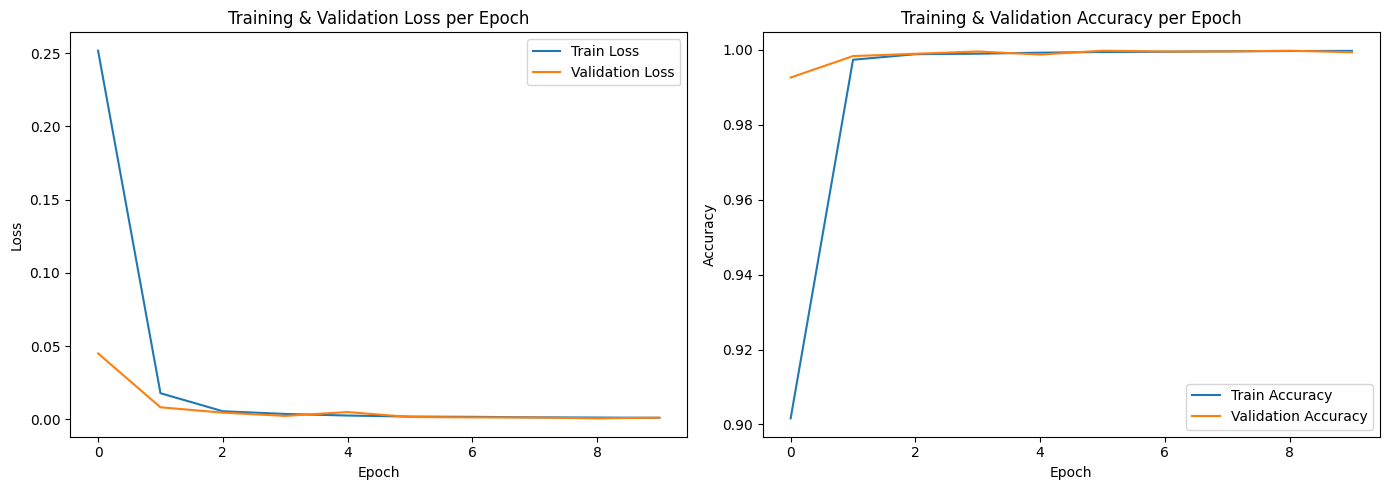

------------------------------------------------------------


In [31]:
# --- Visualisasi History Training (WAJIB) ---
def plot_training_history(history):
    """Membuat plot Loss dan Accuracy selama training."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Training & Validation Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Training & Validation Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

print("\n[Visualisasi Training History (Loss & Accuracy)]")
plot_training_history(history)
print("-" * 60)

In [38]:

model_path_dl = 'models/model_deep_learning.h5'
dl_model.save(model_path_dl)
print(f"✅ Model Deep Learning berhasil disimpan di: {model_path_dl}")

✅ Model Deep Learning berhasil disimpan di: models/model_deep_learning.h5


FINAL EVALUATION DAN RINGKASAN

In [32]:
import pandas as pd
from IPython.display import display


In [33]:
results_df = pd.DataFrame(global_results)

In [34]:
# Sortir berdasarkan Recall dan F1-Score (prioritas model yang aman)
results_df_sorted = results_df.sort_values(by=['Recall', 'F1-Score'], ascending=False)

In [35]:
# Format metrik ke persentase
results_df_sorted['Accuracy'] = (results_df_sorted['Accuracy'] * 100).map('{:.2f}%'.format)
results_df_sorted['Precision'] = (results_df_sorted['Precision'] * 100).map('{:.2f}%'.format)
results_df_sorted['Recall'] = (results_df_sorted['Recall'] * 100).map('{:.2f}%'.format)
results_df_sorted['F1-Score'] = (results_df_sorted['F1-Score'] * 100).map('{:.2f}%'.format)


In [36]:
# Tampilkan tabel hasil komparatif
display(results_df_sorted)

print("\n--- ANALISIS KRITIS: KESELAMATAN (False Negative) ---")
print("FN = Jumlah jamur beracun yang diprediksi salah sebagai aman.")
print(results_df_sorted[['Model', 'False Negative (FN)']])

print("\nKESIMPULAN:")
print("Model Deep Learning (NN) adalah yang paling unggul karena mencapai 0 False Negative, memenuhi kriteria keselamatan krusial untuk proyek ini.")

,Model,Accuracy,Precision,Recall,F1-Score,False Negative (FN)
2,Deep Learning (NN),99.93%,99.88%,100.00%,99.94%,0
1,Random Forest (Advanced ML),96.28%,97.74%,95.51%,96.61%,304
0,Logistic Regression (Baseline),84.72%,86.88%,85.36%,86.11%,992



--- ANALISIS KRITIS: KESELAMATAN (False Negative) ---
FN = Jumlah jamur beracun yang diprediksi salah sebagai aman.
                            Model  False Negative (FN)
2              Deep Learning (NN)                    0
1     Random Forest (Advanced ML)                  304
0  Logistic Regression (Baseline)                  992

KESIMPULAN:
Model Deep Learning (NN) adalah yang paling unggul karena mencapai 0 False Negative, memenuhi kriteria keselamatan krusial untuk proyek ini.
